<a href="https://colab.research.google.com/github/soupsoupr/StrokeSegmentation/blob/main/test_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
import nibabel as nib
import os
# Set the file path to the directory containing the DWI data files
file_path = '/content/drive/MyDrive/ISLES/dataset-ISLES22^public^unzipped^version'

for example_case in range(1,11): # for the first 10 data from ISLES22
    # Set images path.
    dwi_path = os.path.join(file_path, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                            'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" %example_case))
    mask_path = dwi_path.replace('rawdata', 'derivatives').replace('dwi', 'msk')

# Load image data.
dwi_data = []
mask_data = []

dwi_data = nib.load(dwi_path).get_fdata()
mask_data = nib.load(mask_path).get_fdata()

In [139]:
import numpy as np
import cv2

# Duplicate both dwi and label data into two new lists for future process
data_paths = []
mask_paths = []

for i in dwi_data:
    data_paths.append(i)

for i in mask_data:
    mask_paths.append(i)

# Define framework

In [140]:
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [141]:
class CustomDataset(Dataset):
    def __init__ (self, img, mask, transformer):
        self.img = img
        self.mask = mask
        self.transformer = transformer

    def __len__ (self):
        return len(self.img)

    def __getitem__ (self, index):
        img = self.img[index]
        mask = self.mask[index]

        img_open = Image.fromarray(img)
        img_tensor = self.transformer(img_open)

        mask_open = Image.fromarray(mask)
        mask_tensor = self.transformer(mask_open)

        mask_tensor = torch.squeeze(mask_tensor).type(torch.long)

        return img_tensor, mask_tensor

In [142]:
train_transformer = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

test_transformer = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [143]:
sample = 100
train_data = data_paths[:sample]
train_label = mask_paths[:sample]

test_data = data_paths[sample:]
test_label = mask_paths[sample:]

In [144]:
# Train and test sets initalization
train_data = CustomDataset(train_data, train_label, train_transformer)
test_data = CustomDataset(test_data, test_label, test_transformer)

In [145]:
# Train and test set data loaders initalization
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

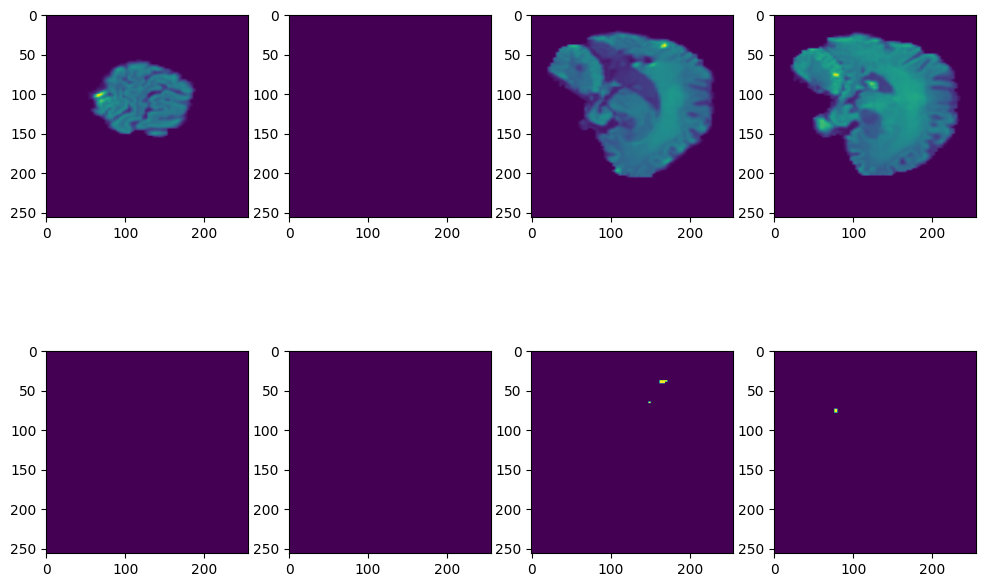

In [149]:
data, label = next(iter(train_loader))
plt.figure(figsize=(12,8))
for i, (data, label) in enumerate(zip(data[:4], label[:4])):
    data = data.permute(1,2,0).numpy()
    label = label.numpy()
    plt.subplot(2,4,i+1)
    plt.imshow(data)
    plt.subplot(2,4,i+5)
    plt.imshow(label)

# U-net down convolution

In [150]:
class Encoder(nn.Module):
    def __init__ (self, in_channels, out_channels):
        super(Encoder.self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.RelU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.RelU(inplace=True),
        )
        self.maxpool = nn.MaxPool2d(kernel_sze=2, stride=2)

    def forward(self, x, if_pool=True):
        if if_pool:
            x = self.maxpool(x)
        x = self.conv_relu(x)
        return x

# U-net up convolution

In [ ]:
class Decoder(nn.Module):
    def __init__ (self, channels):
        super(Decoder.self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(2*channels, channels, kernel_size=3, padding=1),
            nn.RelU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.RelU(inplace=True),
        )
        self.upconv_relu = nn.Sequential(
            nn.ConvTranspose2d(channels, channels//2, kernel_size=3, stride=3, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
        )

        def forward(self.x):
            x = self.conv_relu(x)
            x = self.upconv_relu(x)
            return x

